# Style Transfer
In this notebook we will implement the style transfer technique from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf).

The general idea is to take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is [SqueezeNet](https://arxiv.org/abs/1602.07360), a small model that has been trained on ImageNet. You could use any network, but we chose SqueezeNet here for its small size and efficiency.

Here's an example of the images you'll be able to produce by the end of this notebook:

![caption](example_styletransfer.png)


# Part 0: Setup

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

import matplotlib.pyplot as plt

from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

We provide you with some helper functions to deal with images, since for this part of the assignment we're dealing with real JPEGs, not CIFAR-10 data.

In [2]:
from cs231n.style_transfer_pytorch import preprocess, deprocess, rescale, rel_error, features_from_img

CHECKS_PATH = None

# Local
CHECKS_PATH = 'style-transfer-checks.npz'

# Colab
#CHECKS_PATH = '/content/drive/My Drive/{}/{}'.format(FOLDERNAME, 'style-transfer-checks.npz')

assert CHECKS_PATH is not None, "[!] Choose path to style-transfer-checks.npz"

STYLES_FOLDER = CHECKS_PATH.replace('style-transfer-checks.npz', 'styles')

answers = dict(np.load(CHECKS_PATH))


Pytorch has two separate types for Tensors that contain floating-point numbers: one for operations on the CPU (`torch.FloatTensor`), and one using CUDA for operations on the GPU (`torch.cuda.FloatTensor`).
We'll be using this type variable more later, so we need to set the tensor type to one of them.

In [3]:
dtype = torch.FloatTensor
# Uncomment out the following line if you're on a machine with a GPU set up for PyTorch!
#dtype = torch.cuda.FloatTensor 

In [4]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

# Part 1: Computing Loss

We're going to compute the three components of our loss function now. The loss function is a weighted sum of three terms: content loss + style loss + total variation loss. You'll fill in the functions that compute these weighted terms below.

## Part 1A: Content loss

We can generate an image that reflects the content of one image and the style of another by incorporating both in our loss function. We want to penalize deviations from the content of the content image and deviations from the style of the style image. We can then use this hybrid loss function to perform gradient descent **not on the parameters** of the model, but instead **on the pixel values** of our original image.

Let's first write the content loss function. Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We only care about the content representation of one layer of the network (say, layer $\ell$), that has feature maps $A^\ell \in \mathbb{R}^{1 \times C_\ell \times H_\ell \times W_\ell}$. $C_\ell$ is the number of filters/channels in layer $\ell$, $H_\ell$ and $W_\ell$ are the height and width. We will work with reshaped versions of these feature maps that combine all spatial positions into one dimension. Let $F^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the current image and $P^\ell \in \mathbb{R}^{C_\ell \times M_\ell}$ be the feature map for the content source image where $M_\ell=H_\ell\times W_\ell$ is the number of elements in each feature map. Each row of $F^\ell$ or $P^\ell$ represents the vectorized activations of a particular filter, convolved over all positions of the image. Finally, let $w_c$ be the weight of the content loss term in the loss function.

Then the content loss is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

Implement `content_loss` in `cs231n/style_transfer_pytorch.py`

Test your content loss. You should see errors less than 0.001.

In [6]:
from cs231n.style_transfer_pytorch import content_loss, extract_features, features_from_img

def content_loss_test(correct):
    content_image = '%s/tubingen.jpg' % (STYLES_FOLDER)
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size, cnn)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(dtype)
    feats = extract_features(bad_img, cnn)
    
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer]).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(answers['cl_out'])

Maximum error is 0.000


## Part 1B: Style loss

Now we can tackle the style loss. For a given layer $\ell$, the style loss is defined as follows:

First, compute the Gram matrix $G$ which represents the correlations between the values in each channel of the feature map (i.e. the "responses" of the filter responsible for that channel), where $F$ is as above. The Gram matrix is an approximation of the covariance matrix -- it tells us how every channel's values (i.e. that filter's activations) correlate with every other channel's values. If we have $C$ channels, matrix $G$ will be of shape $(C, C)$ to capture these correlations.

We want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to do that. There are a variety of ways you could do this, but the Gram matrix is nice because it's easy to compute and in practice shows good results.

Given a feature map $F^\ell$ of shape $(C_\ell, H_\ell, W_\ell)$, we can flatten the height and width dimensions so they're just 1 dimension $M_\ell = H_\ell \times W_\ell$: the new shape of $F^\ell$ is $(C_\ell, M_\ell)$. Then, the Gram matrix has shape $(C_\ell, C_\ell)$ where each element is given by the equation:

$$G_{ij}^\ell  = \sum_k F^{\ell}_{ik} F^{\ell}_{jk}$$

Assuming $G^\ell$ is the Gram matrix from the feature map of the current image, $A^\ell$ is the Gram Matrix from the feature map of the source style image, and $w_\ell$ a scalar weight term, then the style loss for the layer $\ell$ is simply the weighted Euclidean distance between the two Gram matrices:

$$L_s^\ell = w_\ell \sum_{i, j} \left(G^\ell_{ij} - A^\ell_{ij}\right)^2$$

In practice we usually compute the style loss at a set of layers $\mathcal{L}$ rather than just a single layer $\ell$; then the total style loss is the sum of style losses at each layer:

$$L_s = \sum_{\ell \in \mathcal{L}} L_s^\ell$$

Begin by implementing the Gram matrix computation function `gram_matrix` inside `cs231n\style_transfer_pytorch.py`:

Test your Gram matrix code. You should see errors less than 0.001.

In [26]:
from cs231n.style_transfer_pytorch import gram_matrix
def gram_matrix_test(correct):
    style_image = '%s/starry_night.jpg' % (STYLES_FOLDER)
    style_size = 192
    feats, _ = features_from_img(style_image, style_size, cnn)
    student_output = gram_matrix(feats[5].clone()).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))
    
gram_matrix_test(answers['gm_out'])

Maximum error is 0.000


Next, put it together and implement the style loss function `style_loss` in `cs231n/style_transfer_pytorch.py`

Test your style loss implementation. The error should be less than 0.001.

In [33]:
from cs231n.style_transfer_pytorch import style_loss
def style_loss_test(correct):
    content_image = '%s/tubingen.jpg' % (STYLES_FOLDER)
    style_image = '%s/starry_night.jpg' % (STYLES_FOLDER)
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size, cnn)    
    feats, _ = features_from_img(style_image, style_size, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))

    
style_loss_test(answers['sl_out'])

Error is 0.000


## Part 1C: Total-variation regularization

It turns out that it's helpful to also encourage smoothness in the image. We can do this by adding another term to our loss that penalizes wiggles or "total variation" in the pixel values. 

You can compute the "total variation" as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). Here we sum the total-variation regualarization for each of the 3 input channels (RGB), and weight the total summed loss by the total variation weight, $w_t$:

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$

In `cs231/style_transfer_pytorch.py`, fill in the definition for the TV loss term in `tv_loss`. To receive full credit, your implementation should not have any loops.

Test your TV loss implementation. Error should be less  than 0.0001.

In [35]:
from cs231n.style_transfer_pytorch import tv_loss
from inspect import getsourcelines
import re

def tv_loss_test(correct):
    content_image = '%s/tubingen.jpg' % (STYLES_FOLDER)
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    
    student_output = tv_loss(content_img, tv_weight).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.4f}'.format(error))
    lines, _ = getsourcelines(tv_loss)
    used_loop = any(bool(re.search(r"for \S* in", line)) for line in lines)
    if used_loop:
        print("WARNING!!!! - Your implementation of tv_loss contains a loop! To receive full credit, your implementation should not have any loops")
    
tv_loss_test(answers['tv_out'])

Error is 0.0000


# Part 2: Style Transfer

Now we're ready to string it all together (you shouldn't have to modify this function):

In [36]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

## Generate some pretty pictures!

Try out `style_transfer` on the three different parameter sets below. Make sure to run all three cells. Feel free to add your own, but make sure to include the results of style transfer on the third parameter set (starry night) in your submitted notebook.

* The `content_image` is the filename of content image.
* The `style_image` is the filename of style image.
* The `image_size` is the size of smallest image dimension of the content image (used for content loss and generated image).
* The `style_size` is the size of smallest style image dimension.
* The `content_layer` specifies which layer to use for content loss.
* The `content_weight` gives weighting on content loss in the overall loss function. Increasing the value of this parameter will make the final image look more realistic (closer to the original content).
* `style_layers` specifies a list of which layers to use for style loss. 
* `style_weights` specifies a list of weights to use for each layer in style_layers (each of which will contribute a term to the overall style loss). We generally use higher weights for the earlier style layers because they describe more local/smaller scale features, which are more important to texture than features over larger receptive fields. In general, increasing these weights will make the resulting image look less like the original content and more distorted towards the appearance of the style image.
* `tv_weight` specifies the weighting of total variation regularization in the overall loss function. Increasing this value makes the resulting image look smoother and less jagged, at the cost of lower fidelity to style and content. 

Below the next three cells of code (in which you shouldn't change the hyperparameters), feel free to copy and paste the parameters to play around them and see how the resulting image changes. 

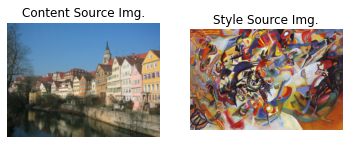

Iteration 0


C:\Users\York You\.conda\envs\dl\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


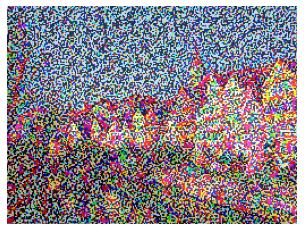

Iteration 100


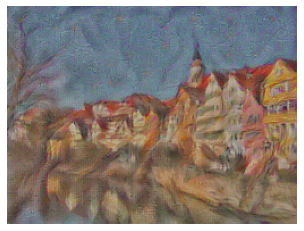

Iteration 199


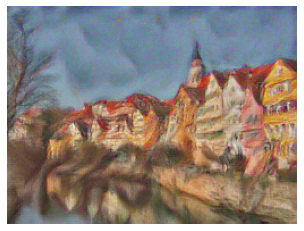

In [37]:
# Composition VII + Tubingen
params1 = {
    'content_image' : '%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image' : '%s/composition_vii.jpg' % (STYLES_FOLDER),
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

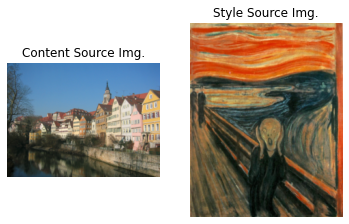

Iteration 0


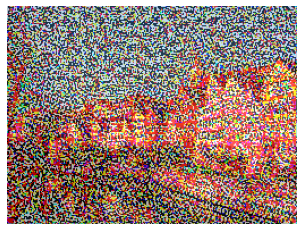

Iteration 100


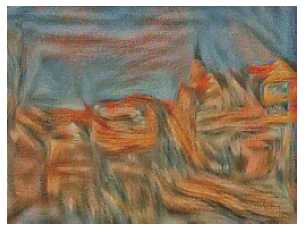

Iteration 199


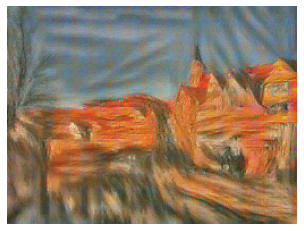

In [38]:
# Scream + Tubingen
params2 = {
    'content_image':'%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image':'%s/the_scream.jpg' % (STYLES_FOLDER),
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

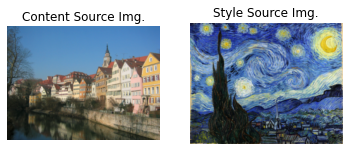

Iteration 0


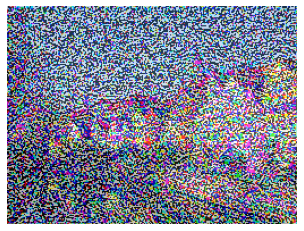

Iteration 100


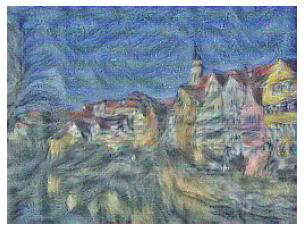

Iteration 199


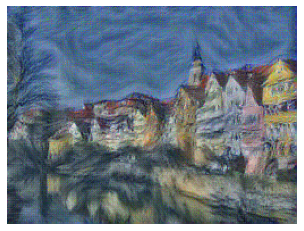

In [39]:
# Starry Night + Tubingen
params3 = {
    'content_image' : '%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image' : '%s/starry_night.jpg' % (STYLES_FOLDER),
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

# Part 3: Feature Inversion

The code you've written can do another cool thing. In an attempt to understand the types of features that convolutional networks learn to recognize, a recent paper "[Understanding Deep Image Representations by Inverting Them](https://arxiv.org/pdf/1412.0035.pdf)" attempts to reconstruct an image from its feature representation. We can easily implement this idea using image gradients from the pretrained network, which is exactly what we did above (but with two different feature representations).

Now, if you set the style weights to all be 0 and initialize the starting image to random noise instead of the content source image, you'll reconstruct an image from the feature representation of the content source image. You're starting with total noise, but you should end up with something that looks quite a bit like your original image.

(Similarly, you could do "texture synthesis" from scratch if you set the content weight to 0 and initialize the starting image to random noise, but we won't ask you to do that here.) 

Run the following cell to try out feature inversion.

[1] Aravindh Mahendran, Andrea Vedaldi, "Understanding Deep Image Representations by Inverting Them", CVPR 2015


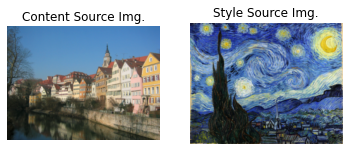

Iteration 0


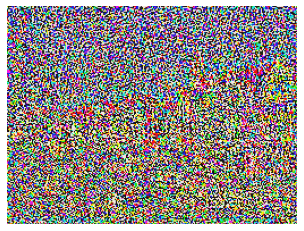

Iteration 100


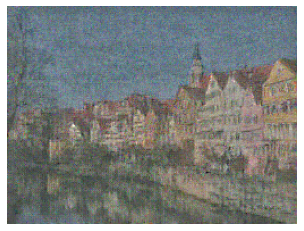

Iteration 199


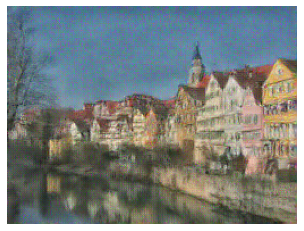

In [40]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : '%s/tubingen.jpg' % (STYLES_FOLDER),
    'style_image' : '%s/starry_night.jpg' % (STYLES_FOLDER),
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)